In [ ]:
# | default_exp models.context
%load_ext autoreload
%autoreload 2


# Context

In [ ]:
# | exports

import base64
import io

import matplotlib.pyplot as plt
from jax import numpy as jnp
from simple_pytree import Pytree

from jaxcmr.math import normalize_magnitude
from jaxcmr.state_analysis import matrix_heatmap
from jaxcmr.typing import Array, Float, Float_


class TemporalContext(Pytree):
    """Temporal context representation for memory search models.

    The `TemporalContext` class implements the drifting, unit-length context representation used by 
    CMR-style models.

    The vector starts with a *start-of-list* unit (index 0) set to 1.0 and one unit per study item
    initialised to 0. On every call to `integrate`, the context drifts toward a normalised
    input vector while remaining unit-length. This initial state is preserved to enable
    drift back to the start-of-list context unit.

    An optional out-of-list context unit (index `item_count + 1`) can be used to simulate post-study
    drift, but unless the drift rate is near 1.0, it does not affect behavior: CMR relies on
    relative differences between context units, which remain unchanged.
    """

    def __init__(self, item_count: int, size: int):
        """Create a new temporal context model.

        Args:
            item_count: the number of items in the context model.
            size: the size of the context representation.
        """
        self.size = size
        self.zeros = jnp.zeros(size)
        self.state = self.zeros.at[0].set(1)
        self.initial_state = self.zeros.at[0].set(1)
        self.next_outlist_unit = item_count + 1

    @classmethod
    def init(cls, item_count: int) -> "TemporalContext":
        """Standardized initialization for a new context model.

        Args:
            item_count: the number of items in the context model.
        """
        return cls(item_count, item_count + 1)

    def integrate(
        self,
        context_input: Float[Array, " context_feature_units"],
        drift_rate: Float_,
    ) -> "TemporalContext":
        """Returns context after integrating input representation, preserving unit length.

        Args:
            context_input: the input representation to be integrated into the contextual state.
            drift_rate: The drift rate parameter.
        """
        context_input = normalize_magnitude(context_input)
        rho = jnp.sqrt(
            1 + jnp.square(drift_rate) * (jnp.square(self.state * context_input) - 1)
        ) - (drift_rate * (self.state * context_input))
        return self.replace(
            state=normalize_magnitude((rho * self.state) + (drift_rate * context_input))
        )

    def _repr_markdown_(self):
        """Returns a markdown representation of the context model."""
        fig, ax = matrix_heatmap(self.state, figsize=(6, 0.6))

        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_yticks([])

        # Remove colorbar safely if desired:
        for coll in ax.collections:
            if hasattr(coll, "colorbar") and coll.colorbar:
                coll.colorbar.remove()

        buf = io.BytesIO()
        fig.savefig(buf, format="png", bbox_inches="tight")
        plt.close(fig)

        encoded = base64.b64encode(buf.getvalue()).decode("utf-8")
        return f'<img src="data:image/png;base64,{encoded}" />'

    @property
    def outlist_input(self) -> Float[Array, " context_feature_units"]:
        """Return the out-of-list context input."""
        return self.zeros.at[self.next_outlist_unit].set(1)

    def integrate_with_outlist(
        self,
        inlist_input: Float[Array, " context_feature_units"],
        ratio: Float_,
        drift_rate: Float_,
    ) -> "TemporalContext":
        """Integrates in-list context input with out-of-list context.

        Will produce errors if no out-of-list context units are available.

        Args:
            inlist_input: the input representation to be integrated into the contextual state.
            ratio: the ratio of out-of-list context to in-list context.
            drift_rate: The drift rate parameter.
        """
        context_input = normalize_magnitude(
            (normalize_magnitude(inlist_input) * ratio)
            + (self.outlist_input * (1 - ratio))
        )
        rho = jnp.sqrt(
            1 + jnp.square(drift_rate) * (jnp.square(self.state * context_input) - 1)
        ) - (drift_rate * (self.state * context_input))
        return self.replace(
            state=normalize_magnitude(
                (rho * self.state) + (drift_rate * context_input)
            ),
            next_outlist_unit=self.next_outlist_unit + 1,
        )

    @classmethod
    def init_expanded(cls, item_count: int) -> "TemporalContext":
        """Initialize a new context model with room for out-of-list contexts.

        Args:
            item_count: the number of items in the context model.
        """
        return cls(item_count, item_count + item_count + 1)


## Notes

In retrieved-context models, `TemporalContext` is typically a vector of continuous values, each tied to a context unit. It’s initialized with a start-of-list unit set to 1, and one unit per study item set to 0. Optionally, an out-of-list unit can simulate post-study drift, but unless drift is near 1.0, it doesn’t affect behavior—CMR relies on relative differences between context units, which remain unchanged.

We provide a standardized `init` class method (from `item_count`) and a flexible `__init__` method (from `item_count` and `size`) for initializing `TemporalContext`.

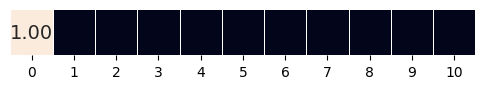

In [ ]:
item_count = 10
size = item_count + 1
drift_rate = 0.3

context = TemporalContext.init(item_count)

# initial state should be 1.0 at the first element, and 0.0 elsewhere
assert context.state[0] == 1.0
assert jnp.all(context.state[1:] == 0.0)

context


This context vector evolves as items are encoded and retrieved, integrating a new contextual input at each step.
At each step $i$, both models update context as

$$
c_i = \rho_i c_{i-1} + \beta \, c_{i}^{IN},
$$

where $\beta$ controls integration of new input $c_i^{IN}$, and $\rho_i$ normalizes the vector (i.e., enforces the unit length of the context vector): 

$$
\rho_i = \sqrt{1 + \beta^2\bigl[(c_{i-1} \cdot c^{IN}_i)^2 - 1\bigr]} \;-\;\beta(c_{i-1} \cdot c^{IN}_i).
$$

This gradual integration yields a recency-based gradient reflecting the order in which items were presented.

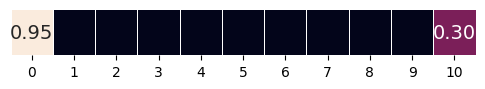

In [ ]:
context_input = jnp.zeros(size).at[-1].set(1)
new_context = context.integrate(context_input, drift_rate)

# test: last element is now non-zero; rest are still 0.0, except for the first element
assert new_context.state[-1] > 0.0
assert jnp.all(new_context.state[1:-1] == 0.0)
assert new_context.state[0] > 0.0

# test: final state vector is unit length
assert jnp.isclose(jnp.linalg.norm(new_context.state), 1.0, atol=1e-6)

new_context


The initial state of the context vector is preserved to enable drift back to the start-of-list context unit.

In [ ]:
# test: the stored `initial_state` is preserved
print(new_context.initial_state)
assert jnp.all(new_context.initial_state == context.state)


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


`TemporalContext` implements the `typing.Context` protocol. As long as a class implements this interface, it's usable by other classes that expect a `Context` object. This allows for easy swapping of different context implementations without changing the rest of the code.

In [ ]:
from jaxcmr.typing import Context


In [ ]:
assert isinstance(new_context, Context), "TemporalContext should implement Context"
